## same as EXP2, the bottleneck model to tackle 250 products, but this time for dense assortment input. Train for more epoches. Sample amount is likely enough

In [ ]:
import AssortmentGenerator as AG
import MarkovGenerator as MG
import Models
import time

import numpy as np
import torch
import torch.nn as nn

from torch import optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt

start_time = time.time()

N_prod = 250        # number of products
Vec_Len = N_prod + 1
Neck_Len = 30       # bottle neck width
EPOCHS = 2000
SAMPLE_AMOUNT = 500000
BATCH_SIZE = 5000
TRAIN_VALI_RATE = 0.9
ADAM_LR = 0.0005

# generate latent parameters
transP = np.load("EXP7_dump/markov_matrix.npy")
lams = np.load("EXP7_dump/arriving_lambda.npy")

model = torch.load("EXP7_dump/bottleneck_model_3.pth")

# generate synthetic data
INPUT = np.zeros((SAMPLE_AMOUNT,Vec_Len))
OUTPUT = np.zeros((SAMPLE_AMOUNT,Vec_Len))
for i in range(SAMPLE_AMOUNT):
    
    # generate input vector, which has length vec_len
    # the first element is 0, which should be ignored when treated as an assortment
    assort = AG.GenAssortment_Abundant(N_prod)    
    INPUT[i] = AG.Product_0(assort)
    OUTPUT[i] = MG.Absorbing_Calculator(lams, transP, assort)

print("data generated!")
print("total time elapse : ",time.time()-start_time)

train_dataset = TensorDataset(torch.Tensor(INPUT[:int(SAMPLE_AMOUNT * TRAIN_VALI_RATE)]),torch.Tensor(OUTPUT[:int(SAMPLE_AMOUNT * TRAIN_VALI_RATE)]))    
vali_dataset = TensorDataset(torch.Tensor(INPUT[int(SAMPLE_AMOUNT * TRAIN_VALI_RATE):]),torch.Tensor(OUTPUT[int(SAMPLE_AMOUNT * TRAIN_VALI_RATE):]))    

train_loader = DataLoader(train_dataset, shuffle=True, batch_size = BATCH_SIZE)
vali_loader = DataLoader(vali_dataset, shuffle=True, batch_size = len(vali_dataset))

optimizer = optim.Adam(model.parameters(), lr = ADAM_LR)
criterion = nn.BCELoss()

training_losses = np.array([])
vali_losses = np.array([])

for epo in range(1,EPOCHS+1):
    if epo % 50 == 0:
        print("epoch : ",epo)
        print(time.time()-start_time)
    
    for step, (IN, TEST) in enumerate(train_loader):
        
        OUT = model(IN)
        loss = criterion(OUT,TEST)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_pure = loss.detach().item()
        loss_base = criterion(TEST,TEST).detach().item()
        training_losses= np.append(training_losses,(loss_pure - loss_base)/loss_base)
        
    for step, (VALI_IN, VALI_TEST) in enumerate(vali_loader):
        VALI_OUT = model(VALI_IN)
        
        RELATIVE_LOSS = nn.functional.l1_loss(VALI_TEST, VALI_OUT, size_average=False, reduce = False, reduction = None) / torch.clamp(VALI_TEST, min = 1/Vec_Len)

        losses = np.mean(torch.clamp(torch.reshape(RELATIVE_LOSS,(-1,)), max=4).detach().numpy())
        
        vali_losses = np.append(vali_losses,losses)

np.save('EXP7_dump/bottleneck_train_loss_Large', training_losses)
np.save('EXP7_dump/bottleneck_vali_loss_Large', vali_losses)
torch.save(model, "EXP7_dump/bottleneck_model_Large.pth")

data generated!
total time elapse :  382.0234065055847
epoch :  50
835.0942549705505
epoch :  100
1299.0565366744995
epoch :  150
1720.5588145256042
epoch :  200
2108.943246126175
epoch :  250
2521.1219704151154
epoch :  300
2942.806494474411
epoch :  350
3358.45831489563
epoch :  400
3769.019059896469
epoch :  450
4160.799366950989
epoch :  500
4552.544983863831
epoch :  550
4948.104934453964
epoch :  600
5337.036396026611
epoch :  650
5732.131959915161
epoch :  700
6120.926271438599
epoch :  750
6510.638135910034
epoch :  800
6901.895179986954
epoch :  850
7290.5155165195465
epoch :  900
7682.080429792404
epoch :  950
8072.161058187485
epoch :  1000
8467.694536685944
epoch :  1050
8859.495658636093
epoch :  1100
9248.748811006546
epoch :  1150
9641.810336351395
epoch :  1200
10033.571015834808
epoch :  1250
10425.9208278656
epoch :  1300
10815.21872973442
epoch :  1350
11209.232590675354
epoch :  1400
11601.235633850098
epoch :  1450
11999.428468942642
epoch :  1500
12390.99446654319

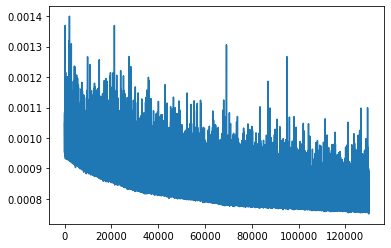

In [10]:
train_loss = np.load('EXP7_dump/bottleneck_train_loss_LARGE.npy')
plt.plot(train_loss[50000:])

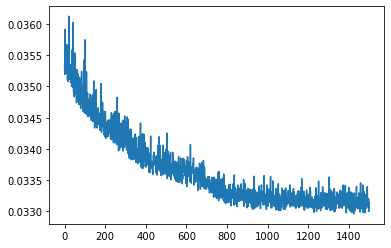

In [13]:
train_loss = np.load('EXP7_dump/bottleneck_vali_loss_LARGE.npy')
plt.plot(train_loss[500:])

## test sparse

/opt/anaconda3/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


(array([4.68372e+05, 9.30000e+01, 8.70000e+01, 1.16000e+02, 1.08000e+02,
        1.22000e+02, 1.45000e+02, 1.60000e+02, 1.74000e+02, 3.26230e+04]),
 array([3.0325292e-08, 2.5000026e-02, 5.0000023e-02, 7.5000018e-02,
        1.0000002e-01, 1.2500001e-01, 1.5000001e-01, 1.7500001e-01,
        2.0000000e-01, 2.2500001e-01, 2.5000000e-01], dtype=float32),
 <BarContainer object of 10 artists>)

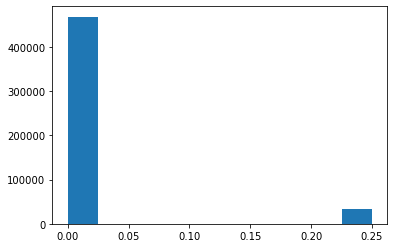

In [2]:
import AssortmentGenerator as AG
import MarkovGenerator as MG
import Models
import time

import numpy as np
import torch
import torch.nn as nn

from torch import optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt

N_prod = 250        # number of products
Vec_Len = N_prod + 1

DENSE_AMOUNT = 2000

import AssortmentGenerator as AG
import MarkovGenerator as MG
import Models
import time

import numpy as np
import torch
import torch.nn as nn

from torch import optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt

start_time = time.time()

N_prod = 250        # number of products
Vec_Len = N_prod + 1
Neck_Len = 30       # bottle neck width
EPOCHS = 2000
SAMPLE_AMOUNT = 500000
BATCH_SIZE = 5000
TRAIN_VALI_RATE = 0.9
ADAM_LR = 0.0005

# generate latent parameters
transP = np.load("EXP7_dump/markov_matrix.npy")
lams = np.load("EXP7_dump/arriving_lambda.npy")

model = torch.load("EXP7_dump/bottleneck_model_LARGE.pth")
INPUT = np.zeros((DENSE_AMOUNT,Vec_Len))
OUTPUT = np.zeros((DENSE_AMOUNT,Vec_Len))
for i in range(DENSE_AMOUNT):
    assort = AG.GenAssortment_Sparse(N_prod)    
    INPUT[i] = AG.Product_0(assort)
    OUTPUT[i] = MG.Absorbing_Calculator(lams, transP, assort)


INPUT=torch.Tensor(INPUT)
OUTPUT = torch.Tensor(OUTPUT)

MODEL_OUT = model(INPUT)

RELATIVE_LOSS = nn.functional.l1_loss(OUTPUT, MODEL_OUT, size_average=False, reduce = False, reduction = None) / torch.clamp(OUTPUT, min = 1/Vec_Len)

losses = torch.clamp(torch.reshape(RELATIVE_LOSS,(-1,)), max=0.25).detach().numpy()

plt.hist(losses)

## test 3/4 dense

(array([373134.,   3849.,   3901.,   3898.,   4154.,   4227.,   4510.,
          4545.,   4757.,  95025.]),
 array([4.50229898e-08, 2.50000414e-02, 5.00000343e-02, 7.50000328e-02,
        1.00000024e-01, 1.25000030e-01, 1.50000021e-01, 1.75000012e-01,
        2.00000003e-01, 2.25000009e-01, 2.50000000e-01], dtype=float32),
 <BarContainer object of 10 artists>)

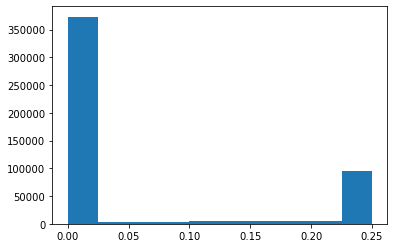

In [7]:
N_prod = 250        # number of products
Vec_Len = N_prod + 1

DENSE_AMOUNT = 2000

model = torch.load("EXP7_dump/bottleneck_model_LARGE.pth")
INPUT = np.zeros((DENSE_AMOUNT,Vec_Len))
OUTPUT = np.zeros((DENSE_AMOUNT,Vec_Len))
for i in range(DENSE_AMOUNT):
    assort = AG.GenAssortment_Even(N_prod, 26/100)    
    INPUT[i] = AG.Product_0(assort)
    OUTPUT[i] = MG.Absorbing_Calculator(lams, transP, assort)


INPUT=torch.Tensor(INPUT)
OUTPUT = torch.Tensor(OUTPUT)

MODEL_OUT = model(INPUT)

RELATIVE_LOSS = nn.functional.l1_loss(OUTPUT, MODEL_OUT, size_average=False, reduce = False, reduction = None) / torch.clamp(OUTPUT, min = 1/Vec_Len)

losses = torch.clamp(torch.reshape(RELATIVE_LOSS,(-1,)), max=0.25).detach().numpy()

plt.hist(losses)

## dense

(array([79418., 88574., 75724., 58021., 42135., 30829., 22925., 17538.,
        13249., 73587.]),
 array([4.0908344e-07, 2.0000038e-01, 4.0000033e-01, 6.0000026e-01,
        8.0000025e-01, 1.0000002e+00, 1.2000002e+00, 1.4000001e+00,
        1.6000000e+00, 1.8000001e+00, 2.0000000e+00], dtype=float32),
 <BarContainer object of 10 artists>)

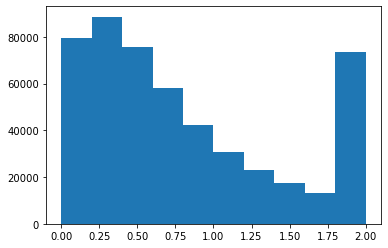

In [19]:
DENSE_AMOUNT = 2000


INPUT = np.zeros((DENSE_AMOUNT,Vec_Len))
OUTPUT = np.zeros((DENSE_AMOUNT,Vec_Len))
for i in range(DENSE_AMOUNT):
    assort = AG.GenAssortment_Fixed(N_prod, fixed_num = N_prod-1)    
    INPUT[i] = AG.Product_0(assort)
    OUTPUT[i] = MG.Absorbing_Calculator(lams, transP, assort)


INPUT=torch.Tensor(INPUT)
OUTPUT = torch.Tensor(OUTPUT)

MODEL_OUT = model(INPUT)

RELATIVE_LOSS = nn.functional.l1_loss(OUTPUT, MODEL_OUT, size_average=False, reduce = False, reduction = None) / torch.clamp(OUTPUT, min = 1/Vec_Len)

losses = torch.clamp(torch.reshape(RELATIVE_LOSS,(-1,)), max=2).detach().numpy()

plt.hist(losses)